# monitor_workflow_and_report_results

Top-level Notebook for monitoring and reporting results of workflow DRS data access scale tests.

In [145]:
import os
import time
from datetime import datetime
from pathlib import Path

import psutil

# Custom Setup for Execution Environment

## Setup for Michael's Broad laptop.

In [146]:
# Enable external development setup
external_development=True

In [147]:
# TODO Set this differently for running in Terra Jupyter Cloud Environment.
if external_development:
    NOTEBOOK_EXECUTION_DIRECTORY="/Users/mbaumann/Repos/mbaumann-broad/"
    %cd {NOTEBOOK_EXECUTION_DIRECTORY}

/Users/mbaumann/Repos/mbaumann-broad


In [148]:
if external_development:
    # The processing performed by this Notebook requires grep with PCRE
    # support, which the version of grep that comes with MacOS Monterey
    # does not provide. Therefore, install it with homebrew and add to PATH:
    # $ brew install grep
    os.environ['PATH'] = f"/usr/local/opt/grep/libexec/gnubin:{os.environ['PATH']}"

    # The processing performed by this Notebook requires sed "-z" option
    # support, which the version of sed that comes with MacOS Monterey
    # does not provide. Therefore, install it with homebrew and add to PATH:
    # $ brew install gnu-sed
    os.environ['PATH'] = f"/usr/local/opt/gnu-sed/libexec/gnubin:{os.environ['PATH']}"

    # The processing performed by this Notebook requires xargs "-a" option
    # support, which the version of sed that comes with MacOS Monterey
    # does not provide. Therefore, install it with homebrew and add to PATH:
    # $ brew install findutils
    os.environ['PATH'] = f"/usr/local/opt/findutils/libexec/gnubin:{os.environ['PATH']}"

    if os.environ.get('WORKSPACE_BUCKET') is None:
        # Workspace bucket used by: `DRS and Signed URL Development - Dev`
        # WORKSPACE_BUCKET="gs://fc-b14e50ee-ccbe-4ee9-9aa4-f4e4ff85bc03"
        WORKSPACE_BUCKET="gs://fc-26863db0-1fe6-463b-a05b-9f8c8cb33dac"
        os.environ['WORKSPACE_BUCKET'] = WORKSPACE_BUCKET

In [149]:
os.environ['PATH']

'/usr/local/opt/findutils/libexec/gnubin:/usr/local/opt/gnu-sed/libexec/gnubin:/usr/local/opt/grep/libexec/gnubin:/usr/local/opt/findutils/libexec/gnubin:/usr/local/opt/gnu-sed/libexec/gnubin:/usr/local/opt/grep/libexec/gnubin:/usr/local/opt/findutils/libexec/gnubin:/usr/local/opt/gnu-sed/libexec/gnubin:/usr/local/opt/grep/libexec/gnubin:/usr/local/opt/findutils/libexec/gnubin:/usr/local/opt/gnu-sed/libexec/gnubin:/usr/local/opt/grep/libexec/gnubin:/usr/local/opt/findutils/libexec/gnubin:/usr/local/opt/gnu-sed/libexec/gnubin:/usr/local/opt/grep/libexec/gnubin:/usr/local/opt/findutils/libexec/gnubin:/usr/local/opt/gnu-sed/libexec/gnubin:/usr/local/opt/grep/libexec/gnubin:/usr/local/opt/gnu-sed/libexec/gnubin:/usr/local/opt/grep/libexec/gnubin:/usr/local/opt/gnu-sed/libexec/gnubin:/usr/local/opt/grep/libexec/gnubin:/Users/mbaumann/opt/miniconda3/bin:/Users/mbaumann/opt/anaconda3/condabin:/Users/mbaumann/Tools/google-cloud-sdk/bin:/usr/local/opt/openjdk@11/bin:/usr/local/bin:/usr/local/bi

# Manual Input/Configuration

Enter the workflow submission id, which is available from Job Manager
after the workflow is started.
For example:
```
 WF_SUBMISSION_ID="1a72b974-00c4-4316-86d5-7a7b1045f9ef"
```

In [150]:
#TODO Uncomment this line when using as a template Notebook
# WF_SUBMISSION_ID = "<Enter workflow submission id as shown above.>"
#WF_SUBMISSION_ID="1a72b974-00c4-4316-86d5-7a7b1045f9ef"
# md5_n_by_m_scatter 100 files
WF_SUBMISSION_ID="c2557d8e-db40-4bac-8005-4488c5dd290c"

Enter the start time for the workflow using UTC/GMT in this format:
```
2022/02/19 01:33:05
YYYY/MM/DD HH:MM:SS
```

For example, the current time in UTC in this format is:

In [151]:
datetime.utcnow().strftime("%Y/%m/%d %H:%M:%S")

'2022/03/21 06:21:43'

In [152]:
#TODO Uncomment this line when using as a template Notebook
# WF_START_TIME = "<Enter UTC date/time in the format above.>"
WF_START_TIME = datetime.utcnow().strftime("%Y/%m/%d %H:%M:%S")

## Processing Steps to Run

In [172]:
monitor_workflow=False
copy_workflow_logs=False
extract_timeseries_data=False
display_results=True

# Constants

In [154]:
WORKSPACE_BUCKET=os.environ['WORKSPACE_BUCKET']
WORKSPACE_BUCKET

'gs://fc-26863db0-1fe6-463b-a05b-9f8c8cb33dac'

In [155]:
WS_WF_GS_URI=f"{WORKSPACE_BUCKET}/{WF_SUBMISSION_ID}"
WS_WF_GS_URI

'gs://fc-26863db0-1fe6-463b-a05b-9f8c8cb33dac/c2557d8e-db40-4bac-8005-4488c5dd290c'

In [156]:
TEST_RESULTS_DIR=Path('./test_results').resolve().as_posix()
! mkdir -p {TEST_RESULTS_DIR}
TEST_RESULTS_DIR

'/Users/mbaumann/Repos/mbaumann-broad/test_results'

In [157]:
WF_TEST_RESULTS_DIR=os.path.join(TEST_RESULTS_DIR, f"submission_{WF_SUBMISSION_ID}")
! mkdir -p {WF_TEST_RESULTS_DIR}
WF_TEST_RESULTS_DIR

'/Users/mbaumann/Repos/mbaumann-broad/test_results/submission_c2557d8e-db40-4bac-8005-4488c5dd290c'

In [158]:
WF_TEST_RESULTS_WORKFLOW_LOGS_DIR=os.path.join(WF_TEST_RESULTS_DIR, "workflow-logs")
WF_TEST_RESULTS_WORKFLOW_LOGS_DIR

'/Users/mbaumann/Repos/mbaumann-broad/test_results/submission_c2557d8e-db40-4bac-8005-4488c5dd290c/workflow-logs'

In [159]:
MONITORING_OUTPUT_DIR=os.path.join(WF_TEST_RESULTS_DIR,
                                   f"monitoring_data_{datetime.strptime(WF_START_TIME, '%Y/%m/%d %H:%M:%S').strftime('%Y%m%d_%H%M%S')}")
! mkdir -p {MONITORING_OUTPUT_DIR}
MONITORING_OUTPUT_DIR

'/Users/mbaumann/Repos/mbaumann-broad/test_results/submission_c2557d8e-db40-4bac-8005-4488c5dd290c/monitoring_data_20220321_062143'

In [160]:
SCRIPTS=Path("./terra-workflow-scale-test-tools/scripts").resolve().as_posix()
SCRIPTS

'/Users/mbaumann/Repos/mbaumann-broad/terra-workflow-scale-test-tools/scripts'

In [174]:
NOTEBOOKS=Path("./terra-workflow-scale-test-tools/notebooks").resolve().as_posix()
NOTEBOOKS

'/Users/mbaumann/Repos/mbaumann-broad/terra-workflow-scale-test-tools/notebooks'

# Functions

In [161]:
def start_monitoring_background_process() -> psutil.Process:
    print("Starting monitoring background process ...")
    process = psutil.Popen(["python3", f"{SCRIPTS}/monitor_response_times.py", "--output-dir", f"{MONITORING_OUTPUT_DIR}" ])
    print(f"Started {process}")
    return process

In [162]:
def stop_monitoring_background_process(process: psutil.Process) -> None:
    print("Stopping monitoring background process ...")
    process.terminate()
    process.wait(60)
    print("Stopped monitoring background process.")

In [163]:
def wait_for_workflow_to_complete() -> None:
    # TODO Implement this
    pretend_duration = 60
    print(f"Pretending to wait for workflow to complete by sleeping {pretend_duration} seconds ...")
    time.sleep(pretend_duration)
    print("Pretending workflow is complete!")

# Monitor response times during workflow execution

In [164]:
if monitor_workflow:
    monitoring_process = start_monitoring_background_process()

    wait_for_workflow_to_complete()

    stop_monitoring_background_process(monitoring_process)

Starting monitoring background process ...
Started psutil.Popen(pid=90899, name='python3.9', status='running', started='23:21:43')
Pretending to wait for workflow to complete by sleeping 60 seconds ...
Pretending workflow is complete!
Stopping monitoring background process ...
Stopped monitoring background process.


# Copy workflow logs from the workspace bucket to the local filesystem

In [165]:
if copy_workflow_logs:
    workflow_logs_path = Path(WF_TEST_RESULTS_WORKFLOW_LOGS_DIR)
    if not workflow_logs_path.exists():
        workflow_logs_path.mkdir(parents=True, exist_ok=False)
        # Copy the logs - this can take a long time (tens of minutes to hours)
        ! {SCRIPTS}/copy_workflow_logs_to_local_fs.sh -s {WS_WF_GS_URI} -d {WF_TEST_RESULTS_WORKFLOW_LOGS_DIR} > {WF_TEST_RESULTS_WORKFLOW_LOGS_DIR}/copy_workflow_logs_to_local_fs.log 2>&1
    else:
        print(f"The workflow-logs directory already exists: {WF_TEST_RESULTS_WORKFLOW_LOGS_DIR}")
        print("Skipping copy of the workflow logs.")
else:
    print("Currently configured to skip copying of workflow logs.")


In [170]:
if extract_timeseries_data:
    ! {SCRIPTS}/extract_drs_localization_timestamps.sh -d {WF_TEST_RESULTS_DIR} # > {WF_TEST_RESULTS_WORKFLOW_LOGS_DIR}/extract_drs_localization_timestamps.log 2>&1


real	0m0.026s
user	0m0.004s
sys	0m0.008s
Done extracting DRS localization time series data to: /Users/mbaumann/Repos/mbaumann-broad/test_results/submission_c2557d8e-db40-4bac-8005-4488c5dd290c/drs_localization_timeseries.tsv


In [171]:
if extract_timeseries_data:
    ! {SCRIPTS}/extract_drs_localization_fallback_timestamps.sh -d {WF_TEST_RESULTS_DIR}  # > {WF_TEST_RESULTS_WORKFLOW_LOGS_DIR}/extract_drs_localization_fallback_timestamps.log 2>&1

+ parse_options -d /Users/mbaumann/Repos/mbaumann-broad/test_results/submission_c2557d8e-db40-4bac-8005-4488c5dd290c
+ local OPTIND
+ getopts d: o
+ case "${o}" in
+ WF_TEST_RESULTS_DIR=/Users/mbaumann/Repos/mbaumann-broad/test_results/submission_c2557d8e-db40-4bac-8005-4488c5dd290c
+ getopts d: o
+ shift 2
+ set +u
+ '[' -z /Users/mbaumann/Repos/mbaumann-broad/test_results/submission_c2557d8e-db40-4bac-8005-4488c5dd290c ']'
+ set -u
+ WORKFLOW_LOG_DIR=/Users/mbaumann/Repos/mbaumann-broad/test_results/submission_c2557d8e-db40-4bac-8005-4488c5dd290c/workflow-logs
+ DRS_LOCALIZATION_FALLBACK_LOG_LINES=/Users/mbaumann/Repos/mbaumann-broad/test_results/submission_c2557d8e-db40-4bac-8005-4488c5dd290c/drs_localization_fallback_log_lines.txt
+ DRS_LOCALIZATION_FALLBACK_TIMESTAMPS=/Users/mbaumann/Repos/mbaumann-broad/test_results/submission_c2557d8e-db40-4bac-8005-4488c5dd290c/drs_localization_fallback_timestamps.txt
+ DRS_LOCALIZATION_FALLBACK_TIMESERIES=/Users/mbaumann/Repos/mbaumann-broad/t

# Display the results of the workflow run

## Workflow DRS localization rates

DRS data access rate per second
Maximum value:	2 seconds
Mean value:		0.5 seconds
95th quantile:	2.0 seconds



FileNotFoundError: [Errno 2] No such file or directory: '/Users/mbaumann/Repos/mbaumann-broad/test_results/submission_c2557d8e-db40-4bac-8005-4488c5dd290c/drs_localization_fallback_timeseries.tsv'

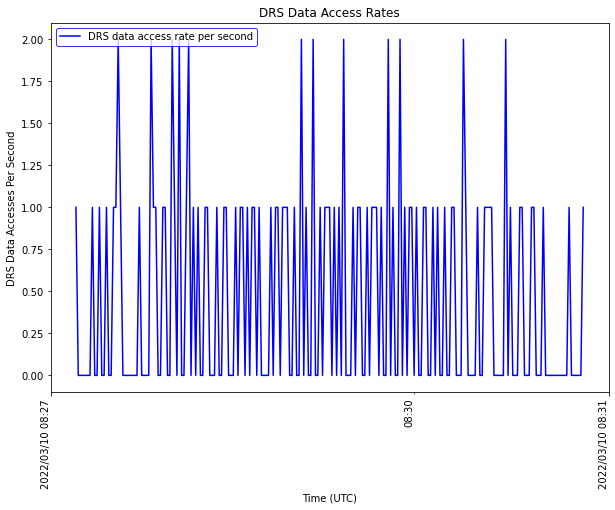

FileNotFoundError: [Errno 2] No such file or directory: '/Users/mbaumann/Repos/mbaumann-broad/test_results/submission_c2557d8e-db40-4bac-8005-4488c5dd290c/drs_localization_fallback_timeseries.tsv'

In [175]:
if display_results:
    %run {NOTEBOOKS}/graph_drs_data_access_rates.ipynb

## Service/endpoint response times

In [169]:
if display_results:
    %run {SCRIPTS}/graph_response_time_data.ipynb TODO